# Tutorial: Getting Started with JAX for machine learning

Having seen (`01_jax.ipynb`) JAX's ability to differentiate and vectorise, we might reasonably consider taking gradients of functions like "the loss function of a model" and vectorising operations like "take the parameter gradients across all samples in the data set".

### Optional: Model training in pure JAX

In [6]:
# NotImplementedError

### Model training with JAX, equinox and optax

Model training with JAX is an obvious enough idea that several libraries emerged in 2019-20 to support abstractions like network layers and utility functions for parameter updates. The most prominent of these are [Flax](https://flax.readthedocs.io/en/latest/) (Google Research) and [Haiku](https://dm-haiku.readthedocs.io/en/latest/index.html) (Google DeepMind), neither of which I find very satisfactory. 

For starting out, I recommend the newer [equinox](https://docs.kidger.site/equinox/). Here is a linear layer implemented for training:

In [62]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx

model_config = {
    "in_size": 2,
    "out_size": 1,
    "seed": 404
}

class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, seed):
        wkey, bkey = jr.split(jr.PRNGKey(seed)) # This is the JAX idiom for non-stateful repeatable RNG
        self.weight = jr.normal(wkey, (out_size, in_size))
        self.bias = jr.normal(bkey, (out_size,))

    def potential(self, r):
        return (self.weight @ r + self.bias).squeeze()

    def field(self, source, r):
        return -jax.vmap(jax.grad(self.potential))(r)

    def __call__(self, source, r):
        return jax.vmap(self.potential)(r)



model = Linear(**model_config)


In [4]:
# Source config and plotting style setup
import matplotlib.pyplot as plt
import scienceplots
from hypermagnetics.sources import configure
from hypermagnetics import plots

plt.style.use(["science", "ieee"])

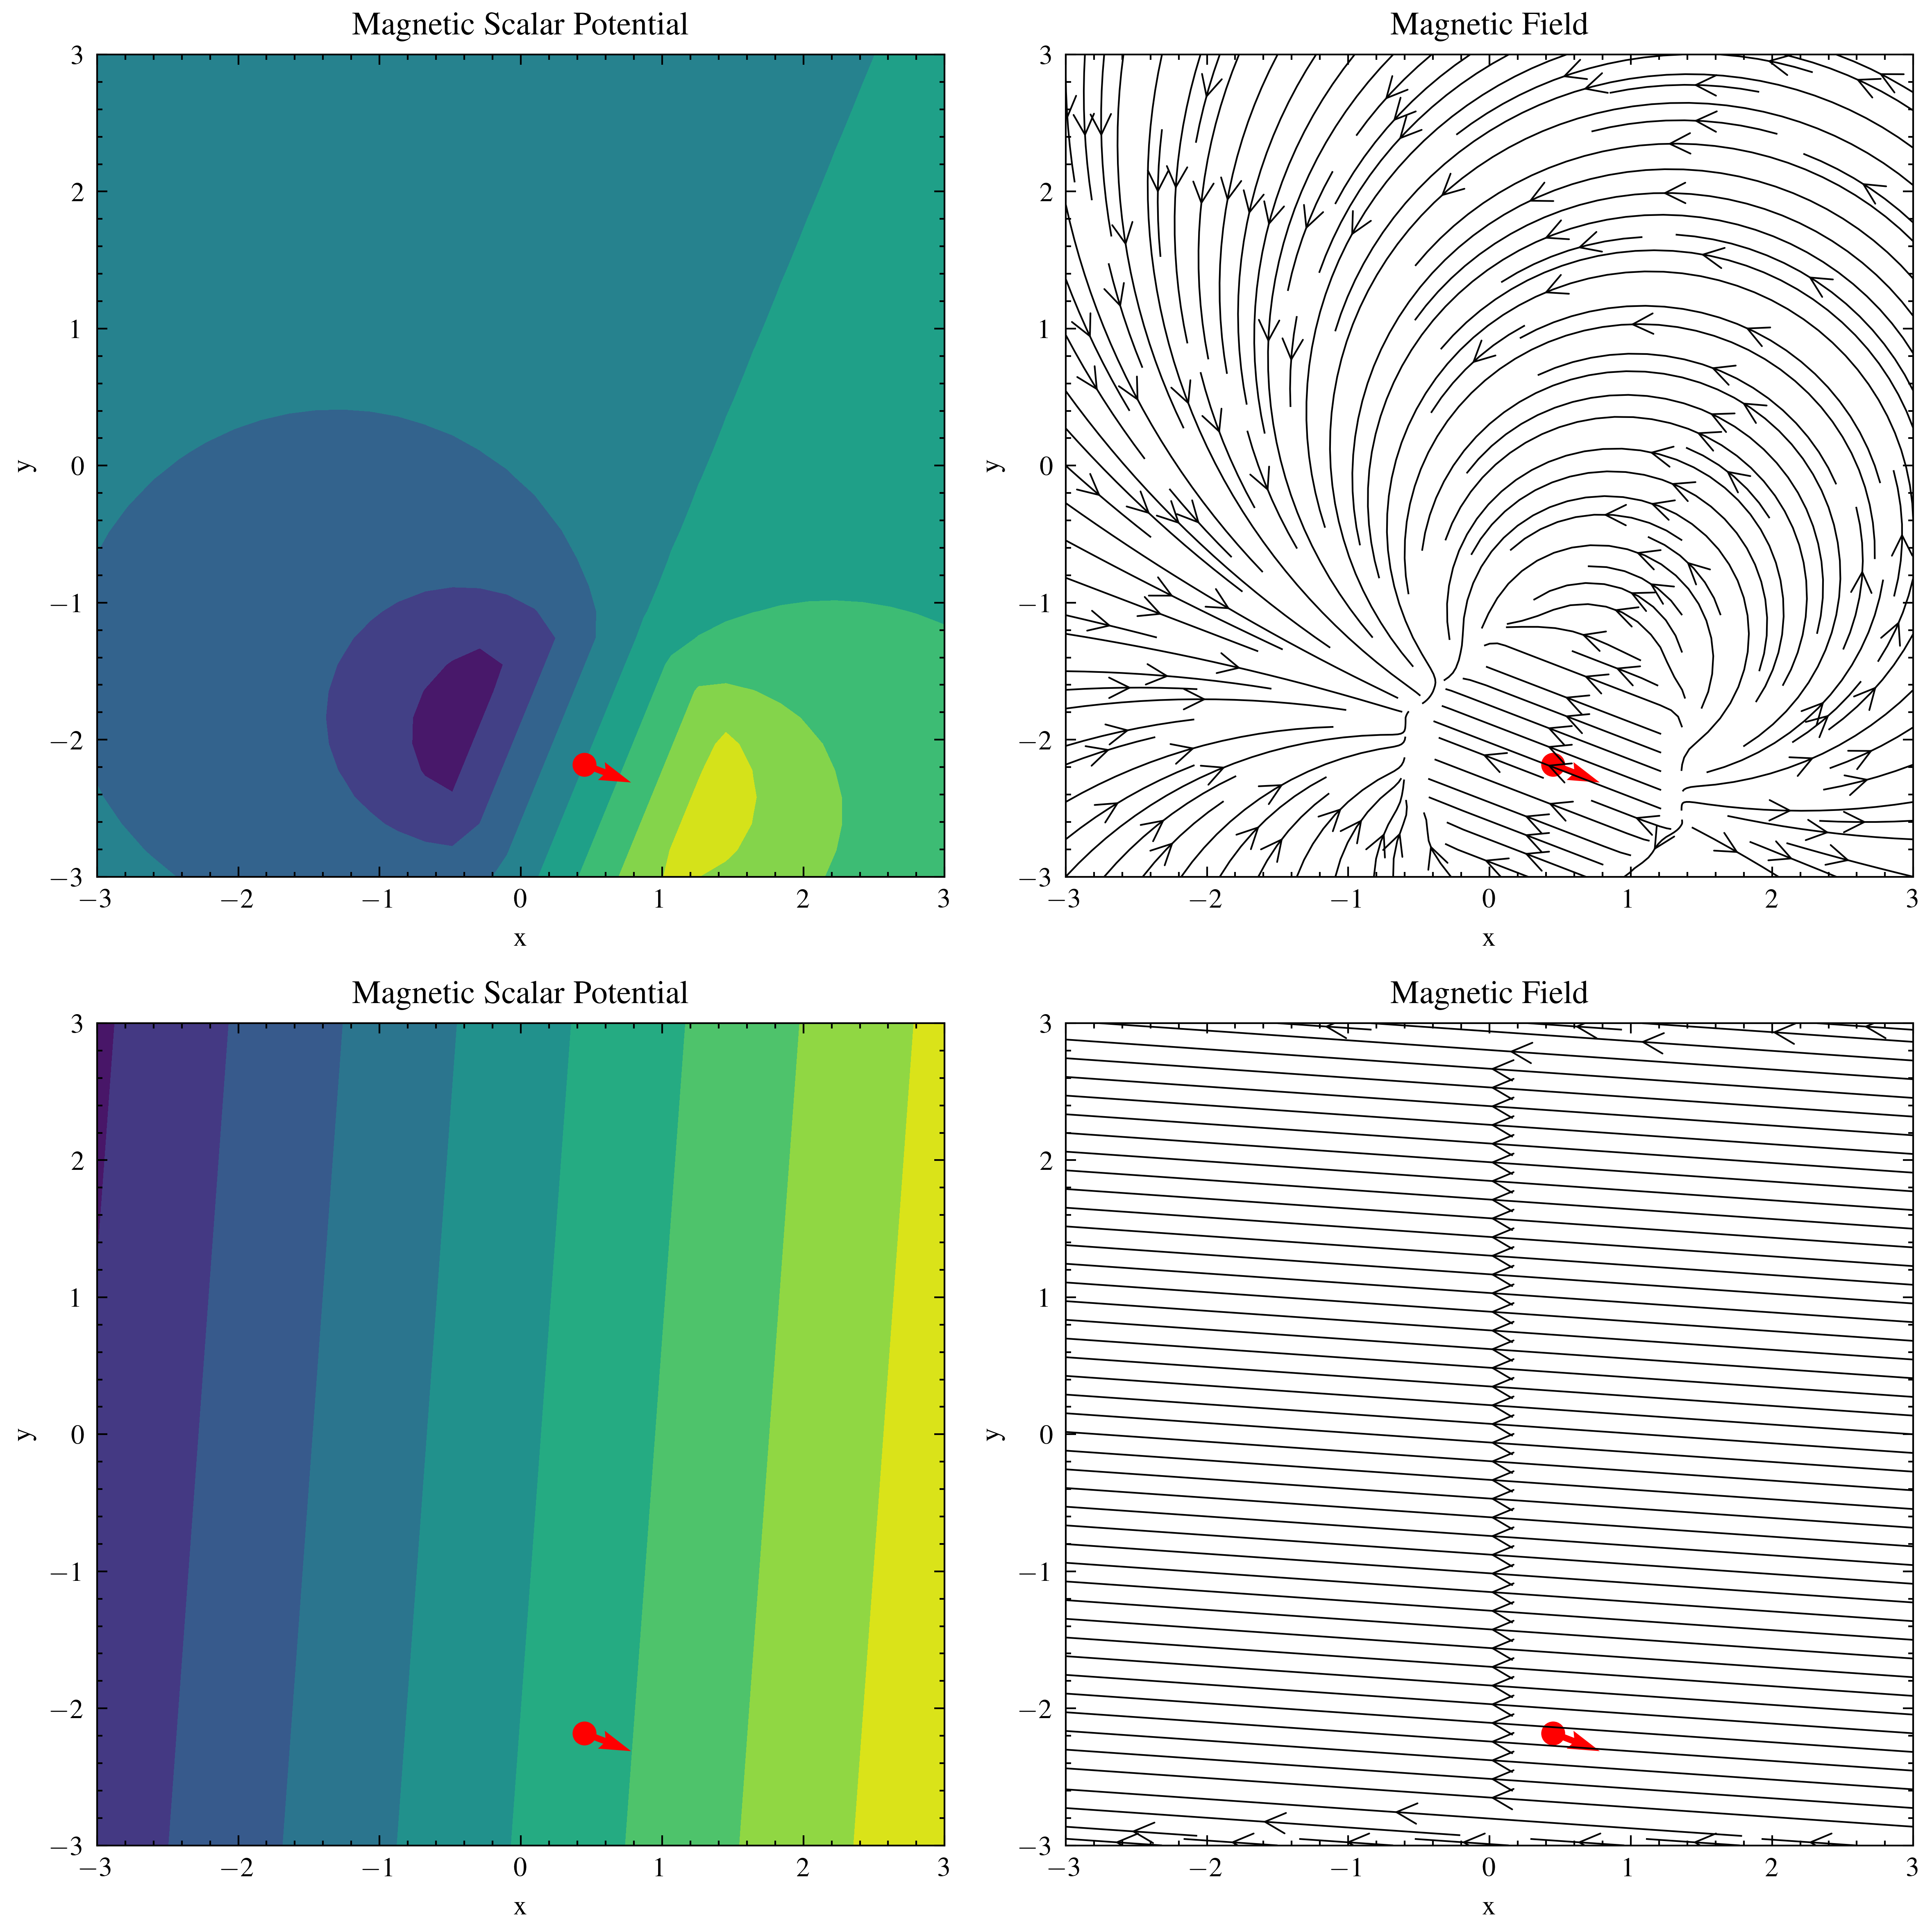

In [61]:
config = {
    "n_samples": 1,
    "n_sources": 1,
    "seed": 242,
    "lim": 3,
    "res": 32,
}

data = configure(**config)
plots(data, model)

### Training

For training we can use [optax](https://optax.readthedocs.io).

In [63]:
@jax.jit
def loss_fn(model, sources, r, y):
    pred_y = model(sources, r)
    return jnp.mean((y - pred_y) ** 2)

print(loss_fn(model, data["sources"], data["r"], data["potential"]))

5.3950644


In [66]:
import optax

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(model)

for epoch in range(2500):
    loss, grads = jax.value_and_grad(loss_fn)(model, data["sources"], data["r"], data["potential"])
    updates, opt_state = optim.update(grads, opt_state)
    model = optax.apply_updates(model, updates)

    if epoch % 100 == 0:
        print(f"{epoch}: {loss:.6f}")

0: 0.000209
100: 0.000185
200: 0.000185
300: 0.000185
400: 0.000185
500: 0.000185
600: 0.000185
700: 0.000185
800: 0.000185
900: 0.000185


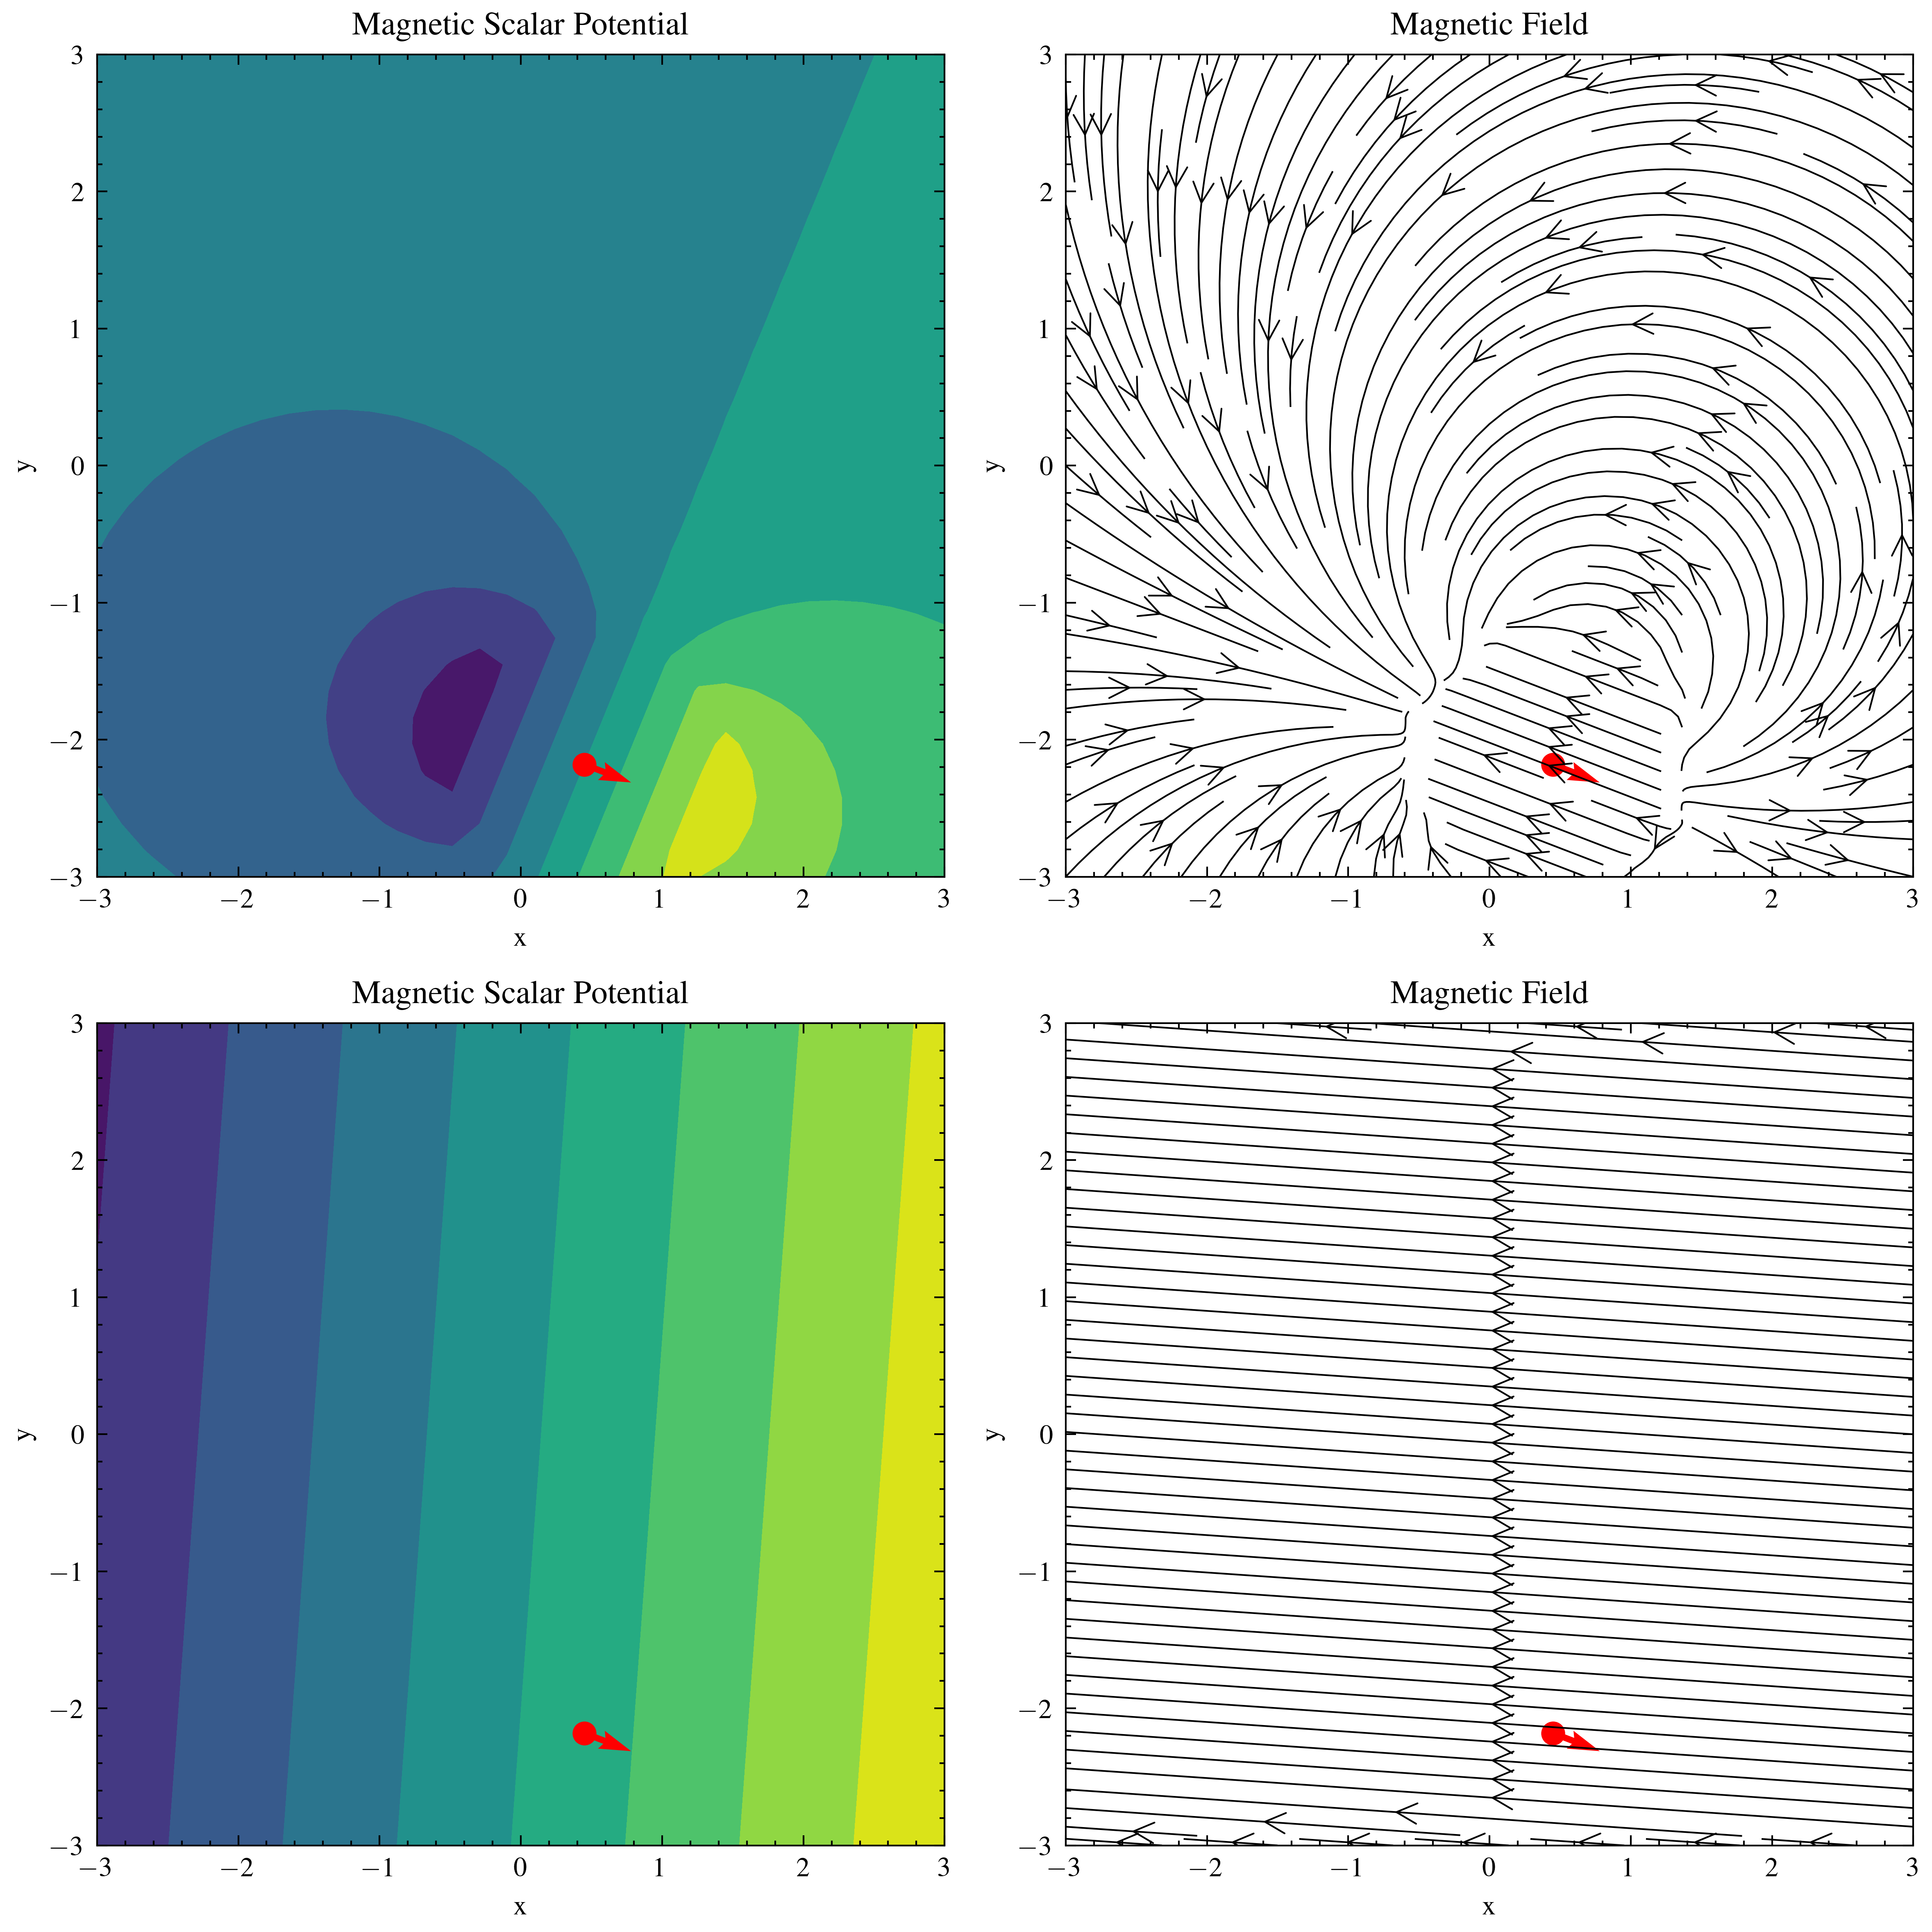

In [67]:
plots(data, model)